## Data 100 Final Project: COVID 19 Dataset
Collaborators:

1. Exploratory Data Analysis

Import, clean, and merge dataframes

Examine County features (which ones?) in relation to death/confirmed/mortality/rate of spread

Produce 2 visualizations

Assignments:

?: Clean states dataframe, ...

Morgan: Import, clean, merge and examine features for California

?: Import, clean, merge and examine features for New York


In [257]:
import numpy as np
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas
from shapely.geometry import Point
import shapefile as shp

from sklearn.linear_model import LinearRegression

#Import Datasets
counties = pd.read_csv('abridged_couties.csv')
deaths = pd.read_csv('time_series_covid19_deaths_US.csv')
cases = pd.read_csv('time_series_covid19_confirmed_US.csv')
states = pd.read_csv('4.18states.csv')

2. Describe any data cleaning or transformations that you perform and why they are motivated by your EDA.

3. Apply relevant inference or prediction methods (e.g., linear regression, logistic regression, or classification and regression trees), 
including, if appropriate, feature engineering and regularization.
4. Use cross-validation or test data as appropriate for model selection and evaluation. Make sure to
carefully describe the methods you are using and why they are appropriate for the question to be
answered.
5. Summarize and interpret your results (including visualization).
6. Provide an evaluation of your approach and discuss any limitations of the methods you used.
7. Describe any surprising discoveries that you made and future work.


## Data Cleaning on COVID Datasets

### States Dataframe 

For data cleaning, a good starting point is to check for null and missing values and interpret what they may mean, before replacing them with any particular value.

In [258]:
# Check for how many missing values are in every column
states.isnull().sum()

Province_State           0
Country_Region           0
Last_Update             83
Lat                      5
Long_                    5
Confirmed                0
Deaths                   0
Recovered               24
Active                   1
FIPS                    82
Incident_Rate            5
People_Tested           84
People_Hospitalized     91
Mortality_Rate           3
UID                      0
ISO3                     0
Testing_Rate            84
Hospitalization_Rate    91
dtype: int64

Replacing information like People_Hospitalized with zero may not be a great idea since we cannot assume there are no people hospitalized, hence, we can replace these missing values with the mean of that country in which specific state data is missing. We can tackle People_Hospitalized, Testing_Rate, Hospitalization_Rate, People_Tested in this way. 

The cell below calculates how many of the total values for each country are not missing. If a value turns out to be zero that means all data points in People_Hospitalized is missing for that country.

In [259]:
countries = states['Country_Region'].value_counts().index.tolist()
people_hospitalization_country_nulls = {}
def usable_vals(col):
    dic = {}
    for country in countries:
        dic[country] = len(states.loc[states['Country_Region'] == country,col].isnull()) - sum(states.loc[states['Country_Region'] == country,col].isnull())
    return dic
People_Hospitalization_country_nulls = usable_vals('People_Hospitalized')
Hospitalization_Rate_country_nulls = usable_vals('Hospitalization_Rate')
print(Hospitalization_Rate_country_nulls == People_Hospitalization_country_nulls)
print('People_Hospitalized \n', usable_vals('People_Hospitalized'))
print('Hospitalization_Rate \n', usable_vals('Hospitalization_Rate'))
print('Testing_Rate \n', usable_vals('Testing_Rate'))
print('People Tested \n', usable_vals('People_Tested'))
print('Mortality Rate \n', usable_vals('Mortality_Rate'))
print(usable_vals('People_Hospitalized') == usable_vals('Hospitalization_Rate') == usable_vals('Testing_Rate') == usable_vals('People_Tested') == usable_vals('Mortality_Rate'))

True
People_Hospitalized 
 {'US': 49, 'China': 0, 'Canada': 0, 'United Kingdom': 0, 'France': 0, 'Australia': 0, 'Netherlands': 0, 'Denmark': 0}
Hospitalization_Rate 
 {'US': 49, 'China': 0, 'Canada': 0, 'United Kingdom': 0, 'France': 0, 'Australia': 0, 'Netherlands': 0, 'Denmark': 0}
Testing_Rate 
 {'US': 56, 'China': 0, 'Canada': 0, 'United Kingdom': 0, 'France': 0, 'Australia': 0, 'Netherlands': 0, 'Denmark': 0}
People Tested 
 {'US': 56, 'China': 0, 'Canada': 0, 'United Kingdom': 0, 'France': 0, 'Australia': 0, 'Netherlands': 0, 'Denmark': 0}
Mortality Rate 
 {'US': 57, 'China': 33, 'Canada': 13, 'United Kingdom': 10, 'France': 10, 'Australia': 8, 'Netherlands': 4, 'Denmark': 2}
False


In [260]:
mortality_dic = {}
for country in countries:
        mortality_dic[country] =  sum(states.loc[states['Country_Region'] == country,'Mortality_Rate'].isnull())
mortality_dic

{'US': 2,
 'China': 0,
 'Canada': 1,
 'United Kingdom': 0,
 'France': 0,
 'Australia': 0,
 'Netherlands': 0,
 'Denmark': 0}

Only the data for US contains values that will be usable so we can go ahead and replace the NaN values in the US data with the mean of that column in the US and from here note that we can only incorporate People_Hospitalized in analysis within the US. 

In [261]:
def replace_nan_with_mean(country, col):
    arr = states[states['Country_Region'] == country][col]
    arr_mean = arr.mean()
    arr.fillna(arr_mean, inplace=True)
    states.loc[states['Country_Region'] == country,col] = arr

replace_nan_with_mean('US','People_Hospitalized')
replace_nan_with_mean('US','Hospitalization_Rate')
replace_nan_with_mean('US','Testing_Rate')
replace_nan_with_mean('US','People_Tested')
replace_nan_with_mean('US','Mortality_Rate')

states.isnull().sum()

/Users/ayushsehgal/opt/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


Province_State           0
Country_Region           0
Last_Update             83
Lat                      5
Long_                    5
Confirmed                0
Deaths                   0
Recovered               24
Active                   1
FIPS                    82
Incident_Rate            5
People_Tested           81
People_Hospitalized     81
Mortality_Rate           1
UID                      0
ISO3                     0
Testing_Rate            81
Hospitalization_Rate    81
dtype: int64

There is still an uncovered NaN value in Mortality_Rate but this time in a different country so we can remove that. Namely, Canada

In [262]:
replace_nan_with_mean('Canada','Mortality_Rate')
states.isnull().sum()

Province_State           0
Country_Region           0
Last_Update             83
Lat                      5
Long_                    5
Confirmed                0
Deaths                   0
Recovered               24
Active                   1
FIPS                    82
Incident_Rate            5
People_Tested           81
People_Hospitalized     81
Mortality_Rate           0
UID                      0
ISO3                     0
Testing_Rate            81
Hospitalization_Rate    81
dtype: int64

In [263]:
dates = ['1/22/20', '1/23/20',
       '1/24/20', '1/25/20', '1/26/20', '1/27/20', '1/28/20', '1/29/20',
       '1/30/20', '1/31/20', '2/1/20', '2/2/20', '2/3/20', '2/4/20', '2/5/20',
       '2/6/20', '2/7/20', '2/8/20', '2/9/20', '2/10/20', '2/11/20', '2/12/20',
       '2/13/20', '2/14/20', '2/15/20', '2/16/20', '2/17/20', '2/18/20',
       '2/19/20', '2/20/20', '2/21/20', '2/22/20', '2/23/20', '2/24/20',
       '2/25/20', '2/26/20', '2/27/20', '2/28/20', '2/29/20', '3/1/20',
       '3/2/20', '3/3/20', '3/4/20', '3/5/20', '3/6/20', '3/7/20', '3/8/20',
       '3/9/20', '3/10/20', '3/11/20', '3/12/20', '3/13/20', '3/14/20',
       '3/15/20', '3/16/20', '3/17/20', '3/18/20', '3/19/20', '3/20/20',
       '3/21/20', '3/22/20', '3/23/20', '3/24/20', '3/25/20', '3/26/20',
       '3/27/20', '3/28/20', '3/29/20', '3/30/20', '3/31/20', '4/1/20',
       '4/2/20', '4/3/20', '4/4/20', '4/5/20', '4/6/20', '4/7/20', '4/8/20',
       '4/9/20', '4/10/20', '4/11/20', '4/12/20', '4/13/20', '4/14/20',
       '4/15/20', '4/16/20', '4/17/20', '4/18/20']
cases['Confirmed'] = cases[dates].sum(axis=1)
cases

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,...,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,Confirmed
0,16,AS,ASM,16,60.0,NaN,American Samoa,US,-14.2710,-170.1320,...,0,0,0,0,0,0,0,0,0,0
1,316,GU,GUM,316,66.0,NaN,Guam,US,13.4443,144.7937,...,130,133,133,133,133,135,135,136,136,2646
2,580,MP,MNP,580,69.0,NaN,Northern Mariana Islands,US,15.0979,145.6739,...,11,11,11,11,11,13,13,13,14,184
3,630,PR,PRI,630,72.0,NaN,Puerto Rico,US,18.2208,-66.5901,...,725,788,897,903,923,974,1043,1068,1118,13655
4,850,VI,VIR,850,78.0,NaN,Virgin Islands,US,18.3358,-64.8963,...,50,51,51,51,51,51,51,51,53,1020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3250,84090055,US,USA,840,90055.0,Unassigned,Wisconsin,US,0.0000,0.0000,...,0,0,0,0,1,1,0,0,0,63
3251,84090056,US,USA,840,90056.0,Unassigned,Wyoming,US,0.0000,0.0000,...,0,0,0,0,0,0,0,0,0,0
3252,84099999,US,USA,840,99999.0,NaN,Grand Princess,US,0.0000,0.0000,...,103,103,103,103,103,103,103,103,103,2566
3253,84070004,US,USA,840,NaN,Michigan Department of Corrections (MDOC),Michigan,US,0.0000,0.0000,...,0,0,0,370,429,472,472,514,550,2807


## State Level Comparisons 

Our exploration can be on the Mortality Rate. We want to explore what are the features specifically of states that lead to the given mortality rate.  As we saw above, there is a lot of missing data in terms of hospitalization in countries other than the US (which could be a helpful metric later on), so we can focus on the US. 

In [264]:
US_States = states[states['Country_Region'] == 'US']
US_States.drop(116, axis=0,inplace=True)
US_States.drop(['Recovered','Active','FIPS','ISO3','Last_Update','Country_Region'],axis=1,inplace=True)

/Users/ayushsehgal/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


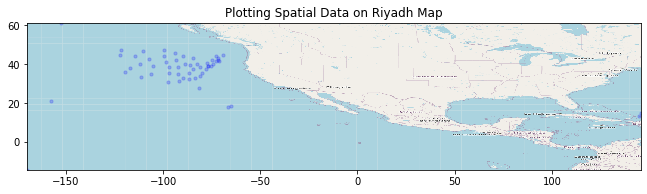

In [265]:
# We can start out by visualizing the Mortality Rate across states and a few patterns in geographical location
bounds = ((min_lon, max_lon, min_lat, max_lat))
us_bg = plt.imread('./img/map.png')

fig, ax = plt.subplots(figsize = (11,11))
ax.scatter(US_States['Long_'], US_States['Lat'], zorder=1, alpha= 0.2, c='b', s=10)
ax.set_title('Plotting Spatial Data on Riyadh Map')
ax.set_xlim(bounds[0],bounds[1])
ax.set_ylim(bounds[2],bounds[3])

ax.imshow(us_bg, zorder=0, extent = bounds, aspect= 'equal')

In [269]:
sns.set(style='whitegrid', palette='pastel', color_codes=True) 
sns.mpl.rc('figure', figsize=(10,6))

In [276]:
shp_path = './District_Boundary.shp'
sf = shp.Reader(shp_path)


ShapefileException: Unable to open ./District_Boundary.dbf or ./District_Boundary.shp.

https://towardsdatascience.com/mapping-with-matplotlib-pandas-geopandas-and-basemap-in-python-d11b57ab5dac

In [266]:
def rmse(predicted, actual):
    return np.sqrt(np.mean((actual - predicted)**2))

In [207]:
models = {}
features = ['People_Hospitalized','Hospitalization_Rate','Testing_Rate']
us_model1_df = US_States[features]
us_model1 = LinearRegression(fit_intercept=False)
us_model1.fit(cali_model1_df, US_States['Mortality_Rate'])
# predicted_mortality = us_model1.predict()

LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=False)